In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import time

In [2]:
from flatland.envs.observations import TreeObsForRailEnv, LocalObsForRailEnv, GlobalObsForRailEnv
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import complex_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator
from flatland.utils.rendertools import RenderTool

## Preprocessing the agent's observation to remove background embellishments

In [3]:
from PIL import Image, ImageDraw, ImageFont
from numpy import array
from pkg_resources import resource_string as resource_bytes

from flatland.utils.graphics_layer import GraphicsLayer

from flatland.core.grid.rail_env_grid import RailEnvTransitions 

from flatland.utils.graphics_pil import PILGL, PILSVG

In [4]:
np.random.seed(1)

# Use the complex_rail_generator to generate feasible network configurations with corresponding tasks
# Training on simple small tasks is the best way to get familiar with the environment
N_agents = 1
width = 20
height = 20
env_seed = 1

TreeObservation = TreeObsForRailEnv(max_depth=2, predictor=ShortestPathPredictorForRailEnv())
LocalGridObs = LocalObsForRailEnv(view_height=10, view_width=2, center=2)
GlobalObs = GlobalObsForRailEnv()
rail_generator = complex_rail_generator(nr_start_goal=10, nr_extra=2, min_dist=8, max_dist=99999, seed=env_seed)
env = RailEnv(width=width, height=height,
              rail_generator= rail_generator,
              schedule_generator=complex_schedule_generator(), 
              number_of_agents=N_agents, 
              obs_builder_object=GlobalObs)

In [5]:
def set_rail_at_new(self, row, col, binary_trans, target=None, is_selected=False, rail_grid=None, num_agents=None,
                show_debug=True):
    
    if binary_trans in self.pil_rail:
        pil_track = self.pil_rail[binary_trans]
        if target is not None:
            target_img = self.station_colors[target % len(self.station_colors)]
            target_img = Image.alpha_composite(pil_track, target_img)
            self.draw_image_row_col(target_img, (row, col), layer=PILGL.TARGET_LAYER)
            if show_debug:
                self.text_rowcol((row + 0.8, col + 0.0), strText=str(target), layer=PILGL.TARGET_LAYER)

        city_size = 1
        if num_agents is not None:
            city_size = max(1, np.log(1 + num_agents) / 2.5)

        self.draw_image_row_col(pil_track, (row, col), layer=PILGL.RAIL_LAYER)
    else:
        print("Illegal rail:", row, col, format(binary_trans, "#018b")[2:], binary_trans)

    if target is not None:
        if is_selected:
            svgBG = self.pil_from_png_file('flatland.png', "Selected_Target.png")
            self.clear_layer(PILGL.SELECTED_TARGET_LAYER, 0)
            self.draw_image_row_col(svgBG, (row, col), layer=PILGL.SELECTED_TARGET_LAYER)

In [6]:
import types

In [7]:
env.reset()
env_renderer = RenderTool(env)

In [8]:
funcType = types.MethodType
env_renderer = RenderTool(env)
env_renderer.gl.set_rail_at = funcType(set_rail_at_new, env_renderer.gl)

In [9]:
env_renderer.render_env(show=False)
env_image = env_renderer.get_image()
env_image.shape

/home/prarit/anaconda3/envs/flatland-rl/lib/python3.6/site-packages/flatland/utils/rendertools.py:396: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


(464, 464, 4)

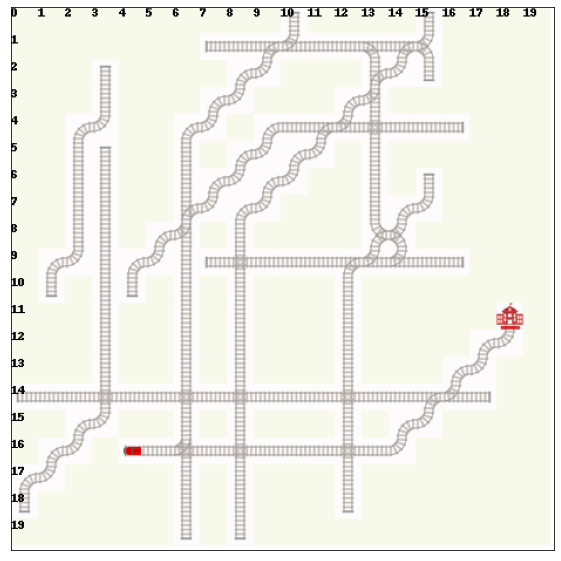

In [10]:
plt.figure(figsize = (10,10))
plt.imshow(env_image)
plt.xticks([])
plt.yticks([])
plt.show()

## Training an Agent

In [11]:
from collections import deque

In [12]:
env.reset()
env_renderer = RenderTool(env)
funcType = types.MethodType
env_renderer = RenderTool(env)
env_renderer.gl.set_rail_at = funcType(set_rail_at_new, env_renderer.gl)

In [13]:
def ScaleAndPermute(img):
    """
    function to scale the pixel values to lie between 0 and 1 and permute the axis to put channels first as opposed to last
    """
    
    img = img/255.0
    img = np.transpose(img, (2,0,1))
    return img


In [14]:
def single_agent_DQN(agent, num_episodes = 10, roll_out = 5, num_max_steps = 20):
    ep_scores = [] # list containing scores from each episode
    scores_window = deque(maxlen = 100) # scores of last 100 episodes
    experience_window = deque(maxlen = roll_out) # agent's experience over the past roll_out steps
    for episode in range(1, num_episodes+1):
        # Reset environment and get initial observations for all agents
        env.reset()
        env_renderer.reset()
        score = 0
        #env_renderer.render_env(show=False)
        env_renderer.render_env(show=True, show_observations=True, show_predictions=False)
        state = ScaleAndPermute(env_renderer.get_image())
        step_ctr = 0
        for steps in range(roll_out-1):
            action = agent.act(state)
            action_dict = {0:action} # for single agent scenario, agent has index 0
            _, all_rewards, done, _ = env.step(action_dict)
            if done[0]:
                break
            #env_renderer.render_env(show=False)
            env_renderer.render_env(show=True, show_observations=True, show_predictions=False)
            next_state = ScaleAndPermute(env_renderer.get_image()) 
            reward = all_rewards[0] # reward of the 0th agent
            single_step_memory = (state, action_dict, all_rewards, next_state, done)
            state = next_state
            experience_window.append(single_step_memory)
            score+=reward
            step_ctr+=1
            
        while True:
            if step_ctr>num_max_steps:
                break
            action = agent.act(state)[0]
            action_dict = {0:action} # for single agent scenario, agent has index 0
            _, all_rewards, done, _ = env.step(action_dict)
            if done['__all__']:
                break
            #env_renderer.render_env(show=False)
            env_renderer.render_env(show=True, show_observations=True, show_predictions=False)
            next_state = ScaleAndPermute(env_renderer.get_image())
            reward = all_rewards[0] # reward of the 0th agent
            single_step_memory = (state, action_dict, all_rewards, next_state, done)
            state = next_state
            experience_window.append(single_step_memory)
            score+=reward
            step_ctr+=1    
            
            agent.step(experience_window)
            
            
        scores_window.append(score)
        ep_scores.append(score)
        
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
            # print('memory size: {}'.format(len(agent.memory)))
            
    return ep_scores

In [15]:
from DuellingDoubleDQNAgent import DuellingDoubleDQNAgent

cuda


In [16]:
agent = DuellingDoubleDQNAgent()

In [17]:
single_agent_DQN(agent)

open_window - pyglet
Episode 3	Average Score: -21.00learning
Episode 4	Average Score: -21.00learning
learning
learning
learning
Episode 5	Average Score: -21.00learning
learning
learning
learning
Episode 6	Average Score: -21.00learning
learning
learning
learning
Episode 7	Average Score: -21.00learning
learning
learning
learning
learning
Episode 8	Average Score: -21.00learning
learning
learning
learning
Episode 9	Average Score: -21.00learning
learning
learning
Episode 10	Average Score: -20.70

[-21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -18.0]